In [3]:
import pandas as pd
import time

In [4]:
# Import dataset and store in pandas dataframe
df = pd.read_csv('working_results.csv', header=None)
df.columns = ["from_url", "to_url", "label", "text_content", "image_index"]

In [5]:
# Let's check the general structure of our data, and get some more information
print(df.shape)
print(df.dtypes)


(10935, 5)
from_url         object
to_url           object
label            object
text_content     object
image_index     float64
dtype: object


In [6]:
# Check how many rows have NaN as values and remove them. In particular if text_content is NaN it is not useful for initial model.
print(df.isna().sum())
df = df[df['text_content'].notna()]

from_url          0
to_url            0
label             0
text_content    819
image_index      93
dtype: int64


## Text Processing

In [7]:
# First step is to standardise text
import string

# Convert words to lowercase
df["text_content"] = df["text_content"].str.lower()

# remove special character / punctuation
df["text_content"] = df["text_content"].str.translate((str.maketrans('','', string.punctuation)))
df["text_content"] = df["text_content"].str.replace('"', "")
df["text_content"] = df["text_content"].str.replace("'", "")

# remove leading and trailing whitespace
df["text_content"] = df["text_content"].str.strip()

df["text_content"].head()

0    we are now hiringnew xd theatersave money when...
1    holiday hourswe are currently looking to hire ...
2    manymanualssearch and download pdf manualsuser...
3    gokartslaser tagsurfside miniature golfclimbin...
4    new save money when you order tickets onlinefu...
Name: text_content, dtype: object

In [8]:
import nltk
from nltk.tokenize import word_tokenize

text_content = df.text_content.str.cat(sep=' ')

tokens = word_tokenize(text_content)

vocabulary = set(tokens)
print(len(vocabulary))

frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

185040


['the',
 'to',
 'and',
 'of',
 'a',
 'you',
 'is',
 'in',
 'for',
 'your',
 'that',
 'on',
 'with',
 'are',
 'it',
 'can',
 'or',
 'this',
 'as',
 'from',
 'be',
 'have',
 'by',
 'not',
 'will',
 'all',
 'we',
 'online',
 'our',
 'torrent',
 'at',
 'has',
 'an',
 'vpn',
 'if',
 'use',
 'more',
 'also',
 'best',
 'casino',
 'any',
 'their',
 'site',
 'other',
 'but',
 'website',
 'free',
 'sites',
 'its',
 'information']

In [9]:
# Let's remove stopwords
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

184902


['online',
 'torrent',
 'vpn',
 'use',
 'also',
 'best',
 'casino',
 'site',
 'website',
 'free',
 'sites',
 'information',
 'one',
 'may',
 'content',
 'get',
 'new',
 'data',
 'download',
 'games',
 'service',
 'like',
 'time',
 'access',
 'services',
 'us',
 'need',
 'many',
 'torrents',
 'tv',
 'using',
 'make',
 'users',
 'files',
 'find',
 'live',
 'game',
 'movies',
 '‚äì',
 'want',
 'internet',
 'privacy',
 'available',
 'even',
 'people',
 'first',
 'pirate',
 'websites',
 'personal',
 'help']

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3)

In [11]:
X_train = train['text_content']
y_train = train['label']
X_test = test['text_content']
y_test = test['label']

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

(7081, 141745) (3035, 141745)


In [13]:
from sklearn.naive_bayes import MultinomialNB
initial_train = time.time()
clf = MultinomialNB().fit(train_vectors, y_train)
final_train = time.time() - initial_train

In [14]:
from  sklearn.metrics  import accuracy_score
initial_test = time.time()
predicted = clf.predict(test_vectors)
final_test = time.time() - initial_test
print(accuracy_score(y_test,predicted))
print(final_train, final_test)

0.8682042833607908
0.031241893768310547 0.0070879459381103516


In [15]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predicted))

[[2088   20]
 [ 380  547]]


## SVM Classifier

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import svm

initial_train = time.time()
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(train_vectors,y_train)
final_train = time.time() - initial_train
# predict the labels on validation dataset
initial_test = time.time()
predictions_SVM = SVM.predict(test_vectors)
final_test = time.time() - initial_test
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)
print(final_train, final_test)

SVM Accuracy Score ->  98.41845140032949
23.382342100143433 9.051156997680664


In [17]:
print(confusion_matrix(y_test, predictions_SVM))

[[2075   33]
 [  15  912]]


In [22]:
## Paramater tuning
import numpy as np

preds = []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    SVM = svm.SVC(C=1.0, kernel=kernel, degree=3, gamma='auto')
    SVM.fit(train_vectors,y_train)
    predictions_SVM = SVM.predict(test_vectors)
    preds.append(accuracy_score(predictions_SVM, y_test))

print(preds)

[0.9841845140032949, 0.6945634266886326, 0.6945634266886326, 0.6945634266886326]


In [28]:
preds = []

C = [0.01, 0.1, 1.0, 10.0, 100.0]
for c in C:
    SVM = svm.SVC(C=c, kernel='linear', degree=1, gamma='auto')
    SVM.fit(train_vectors,y_train)
    predictions_SVM = SVM.predict(test_vectors)
    preds.append(accuracy_score(predictions_SVM, y_test))

print(preds)

[0.699835255354201, 0.9166392092257002, 0.9841845140032949, 0.9887973640856672, 0.9887973640856672]


## KNN Model

ValueError: Illegal format string "1*-"; two marker symbols

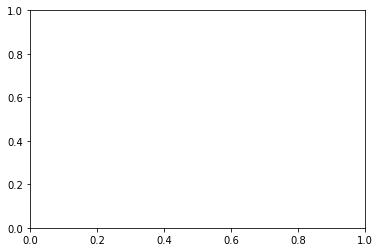

In [23]:
# KNN Classifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

train_accuracies = []
test_accuracies = []
train_cms = []
test_cms = []

neighbours = np.arange(1,20,1)

for neighbour in neighbours:
    knn = KNeighborsClassifier(n_neighbors = neighbour)
    knn.fit(train_vectors, y_train)

    # Training Accuracy & Confusion Matrix
    knn_prediction = knn.predict(train_vectors)
    accuracy = knn.score(train_vectors, y_train)
    train_accuracies.append(accuracy)
    cm = confusion_matrix(y_train, knn_prediction)
    train_cms.append(cm)

    # Testing Accuracy & Confusion Matrix
    knn_prediction = knn.predict(test_vectors)
    accuracy = knn.score(test_vectors, y_test)
    test_accuracies.append(accuracy)
    cm = confusion_matrix(y_test, knn_prediction)
    test_cms.append(cm)



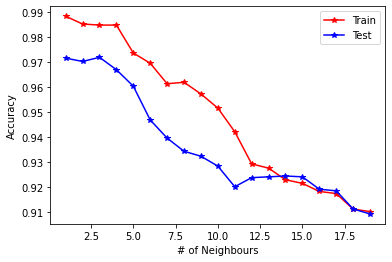

In [24]:
plt.plot(neighbours, train_accuracies, 'r*-', label='Train')
plt.plot(neighbours, test_accuracies, 'b*-', label='Test')
plt.xlabel("# of Neighbours")
plt.ylabel("Accuracy")    
plt.legend()

In [19]:
print(f" \n Train Accuracy: {train_accuracies[0]}")
print(f" \n Train Confusin Matrix: \n {train_cms[0]} \n")
print(f" \n Test Accuracy: {test_accuracies[0]}")
print(f" \n Test Confusin Matrix: \n {test_cms[0]} \n")

 
 Train Accuracy: 0.9884197147295579
 
 Train Confusin Matrix: 
 [[4822   20]
 [  62 2177]] 

 
 Test Accuracy: 0.97166392092257
 
 Test Confusin Matrix: 
 [[2057   51]
 [  35  892]] 

